### What is Cache-Augmented Generation (CAG)?
Cache RAG is a retrieval-free approach that bypasses the usual step of querying external knowledge sources at inference time. Instead, it preloads relevant documents into the LLM's extended context window, precomputes the model’s key‑value (KV) cache, and reuses this during inference—so the model can generate responses without additional retrieval steps 

In [1]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    output_dimension=3072,  # Gemini embedding dimension 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking") 

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


E0000 00:00:1759489457.176431   29510 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759489457.181675   29510 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
### Cache variable
Model_Cache={}

In [4]:
import time

def cache_model(query):
    """
    Caches model responses to avoid redundant computations.
    If the query has been processed before, returns the cached response.
    Otherwise, invokes the model, caches the response, and returns it.
    """
    start_time=time.time()
    if Model_Cache.get(query):
        print("**CACHE HIT**")
        end_time=time.time()
        elapsed_time=end_time-start_time
        print(f"EXECUTION TIME: {elapsed_time:.2f} seconds")
        return Model_Cache.get(query)
    else:
        print("***CACHE MISS – EXECUTING MODEL***")
        start_time = time.time()
        response = llm.invoke(query)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"EXECUTION TIME: {elapsed:.2f} seconds")
        Model_Cache[query] = response
        return response


In [5]:
response=cache_model("hi")
response

***CACHE MISS – EXECUTING MODEL***
EXECUTION TIME: 1.03 seconds


AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--446060fa-21f4-48f3-b307-4308db9d3a83-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [6]:
Model_Cache

{'hi': AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--446060fa-21f4-48f3-b307-4308db9d3a83-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})}

In [7]:
response=cache_model("hi")
response

**CACHE HIT**
EXECUTION TIME: 0.00 seconds


AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--446060fa-21f4-48f3-b307-4308db9d3a83-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [8]:
query="can you give me 500 words on langgraph?"
response =cache_model(query)
print(response)

***CACHE MISS – EXECUTING MODEL***
EXECUTION TIME: 7.56 seconds
content="## LangGraph: Orchestrating Complex LLM Workflows\n\nLangGraph, built on top of LangChain, is a powerful framework designed to orchestrate complex, multi-agent workflows powered by Large Language Models (LLMs). It moves beyond simple sequential chains and allows developers to create sophisticated, stateful applications with branching logic, loops, and parallel execution. Think of it as a visual programming language for LLMs, enabling you to design intricate decision-making processes and interactions between different agents.\n\nAt its core, LangGraph leverages the concept of a **graph**, where nodes represent individual steps in the workflow and edges define the transitions between them. These nodes can be anything from simple LLM calls to complex functions that perform data manipulation, external API calls, or even agent interactions. The edges, on the other hand, dictate the flow of information and control based

In [9]:
query="can you give me 500 words on langgraph?"
response =cache_model(query)
print(response)

**CACHE HIT**
EXECUTION TIME: 0.00 seconds
content="## LangGraph: Orchestrating Complex LLM Workflows\n\nLangGraph, built on top of LangChain, is a powerful framework designed to orchestrate complex, multi-agent workflows powered by Large Language Models (LLMs). It moves beyond simple sequential chains and allows developers to create sophisticated, stateful applications with branching logic, loops, and parallel execution. Think of it as a visual programming language for LLMs, enabling you to design intricate decision-making processes and interactions between different agents.\n\nAt its core, LangGraph leverages the concept of a **graph**, where nodes represent individual steps in the workflow and edges define the transitions between them. These nodes can be anything from simple LLM calls to complex functions that perform data manipulation, external API calls, or even agent interactions. The edges, on the other hand, dictate the flow of information and control based on specific conditio

In [10]:
query="give me 500 words on langgraph?"
response =cache_model(query)
print(response)

***CACHE MISS – EXECUTING MODEL***
EXECUTION TIME: 7.75 seconds
content="## LangGraph: Orchestrating Complex LLM Workflows with State\n\nLangGraph, built on top of LangChain, is a powerful framework designed to orchestrate complex, multi-agent workflows powered by Large Language Models (LLMs). It moves beyond simple sequential chains and allows developers to define intricate, stateful graphs that represent the flow of information and decision-making within their LLM applications. This enables the creation of more sophisticated and robust AI systems capable of handling complex tasks, reasoning, and interacting with the world in a more nuanced way.\n\nAt its core, LangGraph leverages the concept of a **state graph**. This graph consists of:\n\n*   **Nodes:** Represent individual steps in the workflow. These nodes can be anything from LLM calls, tool invocations, data transformations, or even conditional logic.\n*   **Edges:** Define the connections between nodes, dictating the flow of ex

### Advanced Cache RAG"

In [11]:
from __future__ import annotations
from typing import TypedDict, List, Optional
import time

# ---- LangGraph / LangChain ----
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.documents import Document
# from langchain_openai import ChatOpenAI
# from langchain.embeddings import HuggingFaceEmbeddings

# ---- FAISS vector stores ----
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [12]:
# ================= CONFIG =================
VECTOR_DIM = 3072  # Gemini embedding dimension
RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45

# Optional TTL for cache entries (seconds). 0 = disabled.
CACHE_TTL_SEC = 0

In [13]:
# ================= STATE ==================
class RAGState(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

In [14]:
# ----- QA CACHE (EMPTY, SAFE INIT) -----
qa_index = faiss.IndexFlatL2(VECTOR_DIM)  # distance; lower is better
QA_CACHE = FAISS(
    embedding_function=embedding_model,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [15]:
QA_CACHE

In [16]:
# ----- RAG STORE (demo only) -----
RAG_STORE = FAISS.from_texts(
    texts=[
        "LangGraph lets you compose stateful LLM workflows as graphs.",
        "In LangGraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.",
        "Retrieval-Augmented Generation (RAG) retrieves external context and injects it into prompts.",
        "Semantic caching reuses prior answers when new questions are semantically similar."
    ],
    embedding=embedding_model,
)

In [17]:
# ================ NODES ===================
def normalize_query(state: RAGState) -> RAGState:
    """Lowercase and trim the input question for consistent matching."""

    q = (state["question"] or "").strip()
    state["normalized_question"] = q.lower()
    return state

def semantic_cache_lookup(state: RAGState) -> RAGState:
    """Check the cache for a similar question and return the cached answer if found.
    1. If the normalized question is empty, skip cache lookup.
    2. If the cache is empty, skip cache lookup.
    3. Perform similarity search in the cache for the normalized question.
    4. If a similar question is found within the distance threshold, return the cached answer.
    5. If no similar question is found or the cache is empty, proceed without using the cache.
    """

    q = state["normalized_question"]
    state["cache_hit"] = False  # default

    if not q:
        return state

    # ✅ Guard: FAISS crashes if ntotal == 0 and you ask for k>0
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
        return state

    # For FAISS L2 wrapper, this returns (Document, distance) with lower=better
    hits = QA_CACHE.similarity_search_with_score(q, k=CACHE_TOP_K)
    if not hits:
        return state

    best_doc, dist = hits[0]

    # Optional TTL
    if CACHE_TTL_SEC > 0:
        ts = best_doc.metadata.get("ts")
        if ts is None or (time.time() - float(ts)) > CACHE_TTL_SEC:
            return state

    # L2 distance gate (lower = more similar)
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True

    return state

def respond_from_cache(state: RAGState) -> RAGState:
    return state

def retrieve(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    docs = RAG_STORE.similarity_search(q, k=RETRIEVE_TOP_K)
    state["context_docs"] = docs
    return state

def generate(state: RAGState) -> RAGState:
    q = state["question"]
    docs = state.get("context_docs", [])
    ctx = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(docs, start=1)])

    system = (
        "You are a precise RAG assistant. Use the context when helpful. "
        "Cite with [doc-i] markers if you use a fact from the context."
    )
    user = f"Question: {q}\n\nContext:\n{ctx}\n\nWrite a concise answer with citations."

    resp = llm.invoke([{"role": "system", "content": system},
                       {"role": "user", "content": user}])
    state["answer"] = resp.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(docs) + 1)]
    return state

def cache_write(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    a = state.get("answer")
    if not q or not a:
        return state

    QA_CACHE.add_texts(
        texts=[q],
        metadatas=[{
            "answer": a,
            "ts": time.time(),
        }]
    )
    return state

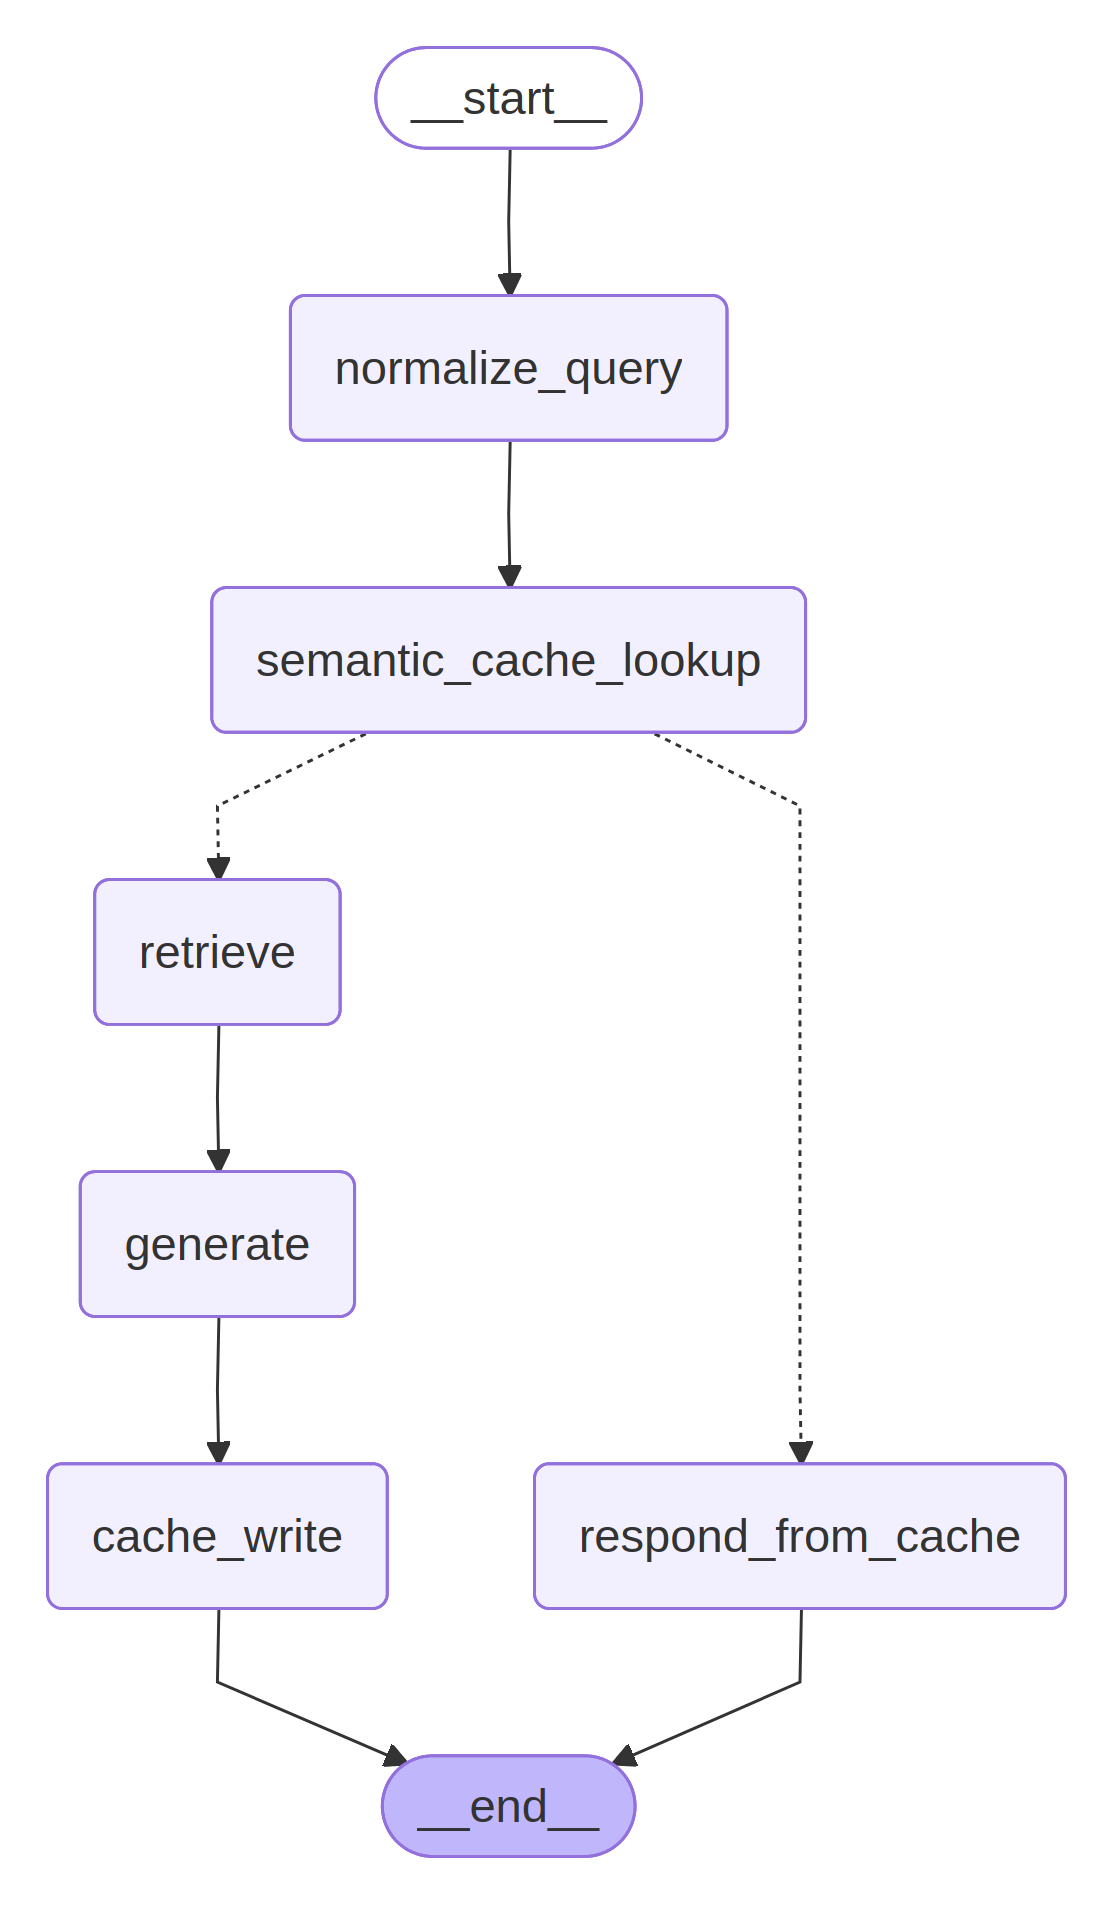

In [18]:
from langchain_core.runnables.graph import MermaidDrawMethod 

import nest_asyncio
nest_asyncio.apply()

# ============== GRAPH WIRING ==============
graph = StateGraph(RAGState)

graph.add_node("normalize_query", normalize_query)
graph.add_node("semantic_cache_lookup", semantic_cache_lookup)
graph.add_node("respond_from_cache", respond_from_cache)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("cache_write", cache_write)

graph.set_entry_point("normalize_query")
graph.add_edge("normalize_query", "semantic_cache_lookup")

def _branch(state: RAGState) -> str:
    return "respond_from_cache" if state.get("cache_hit") else "retrieve"

graph.add_conditional_edges(
    "semantic_cache_lookup",
    _branch,
    {
        "respond_from_cache": "respond_from_cache",
        "retrieve": "retrieve"
    }
)

graph.add_edge("respond_from_cache", END)
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "cache_write")
graph.add_edge("cache_write", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

# Visualize the workflow graph
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [19]:
# ================= DEMO ===================
if __name__ == "__main__":
    thread_cfg = {"configurable": {"thread_id": "demo-user-1"}}

    q1 = "What is LangGraph ?"
    out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
    print("Answer:", out1["answer"])
    print("Citations:", out1.get("citations"))
    print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph enables the creation of stateful LLM workflows as graphs [doc-1]. It also supports node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-2].
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [21]:
q1 = "Explain about LangGraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph enables the creation of stateful LLM workflows as graphs [doc-1]. It also supports node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-2].
Citations: ['(cache)']
Cache hit?: True


In [22]:
q1 = "Explain about LangGraph agents ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph enables the creation of stateful LLM workflows as graphs [doc-1]. It also supports node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-2].
Citations: ['(cache)']
Cache hit?: True


In [23]:
q1 = "Explain about agents in Langgraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph enables the creation of stateful LLM workflows as graphs [doc-1]. It also supports node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-2].
Citations: ['(cache)']
Cache hit?: True
